In [133]:
import glob
import matplotlib.pyplot as plt
from pydicom import dcmread
from PIL import Image
import re
from skimage.restoration import denoise_wavelet
from skimage import img_as_float
from skimage.restoration import denoise_tv_chambolle
from matplotlib import pyplot as plt
from skimage import io
from skimage.metrics import peak_signal_noise_ratio
from pydicom.dataset import FileDataset, FileMetaDataset
from sklearn.metrics import mean_squared_error
import datetime
import os
import tempfile
import pydicom
from pydicom.dataset import FileDataset, FileMetaDataset
from pydicom.uid import UID
import nibabel as nib
import numpy as np



files = glob.glob("/Users/randyllpandohie/Downloads/Siemens Vision Quadra/Subject_136-141/09062022_1_20220609_163454/1-2 dose/*.IMA")
files

ref_files = glob.glob("/Users/randyllpandohie/Downloads/Siemens Vision Quadra/Subject_136-141/09062022_1_20220609_163454/Full_dose/*.IMA")
ref_files

['/Users/randyllpandohie/Downloads/Siemens Vision Quadra/Subject_136-141/09062022_1_20220609_163454/Full_dose/09062022_1.PT.8.231.2022.06.09.18.13.45.991000.4.0.193442502.IMA',
 '/Users/randyllpandohie/Downloads/Siemens Vision Quadra/Subject_136-141/09062022_1_20220609_163454/Full_dose/09062022_1.PT.8.602.2022.06.09.18.13.47.125000.4.0.193451050.IMA',
 '/Users/randyllpandohie/Downloads/Siemens Vision Quadra/Subject_136-141/09062022_1_20220609_163454/Full_dose/09062022_1.PT.8.240.2022.06.09.18.13.46.018000.4.0.193442610.IMA',
 '/Users/randyllpandohie/Downloads/Siemens Vision Quadra/Subject_136-141/09062022_1_20220609_163454/Full_dose/09062022_1.PT.8.328.2022.06.09.18.13.46.288000.4.0.193443666.IMA',
 '/Users/randyllpandohie/Downloads/Siemens Vision Quadra/Subject_136-141/09062022_1_20220609_163454/Full_dose/09062022_1.PT.8.348.2022.06.09.18.13.46.348000.4.0.193443906.IMA',
 '/Users/randyllpandohie/Downloads/Siemens Vision Quadra/Subject_136-141/09062022_1_20220609_163454/Full_dose/09062

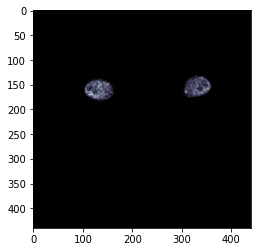

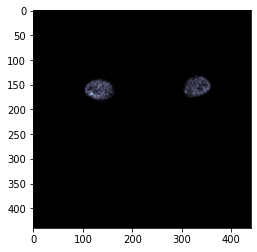

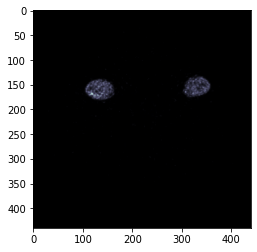

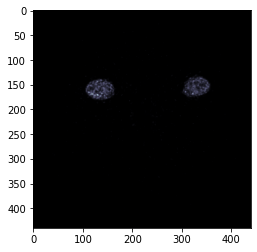

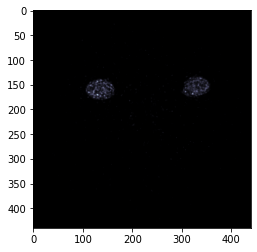

In [51]:


def show_img(img_path):
    ds = dcmread(img_path)
    im = Image.fromarray(ds.pixel_array)
    #im = im.resize((DESIRED_SIZE,DESIRED_SIZE)) 
    #im.show()
    plt.imshow(im, cmap=plt.cm.bone)
    plt.show()
    



files.sort(key=lambda f: int(re.sub('\D', '', f)))
files

ref_files.sort(key=lambda f: int(re.sub('\D', '', f)))

noisy_img = img_as_float(io.imread(files[6]))
ref_img = img_as_float(io.imread(ref_files[6]))
show_img(files[5])
show_img(files[4])
show_img(files[3])
show_img(files[2])
show_img(files[1])

In [64]:
wavelet_smoothed = denoise_wavelet(noisy_img, multichannel=False,
                           method='BayesShrink', mode='soft',
                           rescale_sigma=True,wavelet='db2')

#denoise_TV = denoise_tv_chambolle(noisy_img, weight=0.7, multichannel=False)
denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=0.7, multichannel=False)

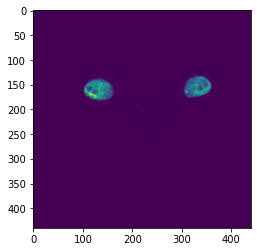

In [65]:
plt.imshow(ref_img)

PSNR of input noisy image =  -30.478510585847847
PSNR of cleaned image =  -30.455164315168073
MSE: 1110.4941


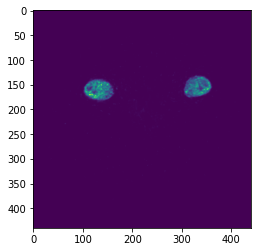

In [66]:
noise_psnr = peak_signal_noise_ratio(ref_img, noisy_img, data_range=1.0)
TV_cleaned_psnr = peak_signal_noise_ratio(ref_img, denoise_TV, data_range=1.0)
print("PSNR of input noisy image = ", noise_psnr)
print("PSNR of cleaned image = ", TV_cleaned_psnr)


mse_tv = mean_squared_error(denoise_TV, ref_img)
print("MSE:",mse_tv)
plt.imshow(noisy_img)

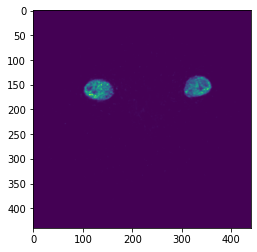

In [67]:
plt.imshow(denoise_TV)



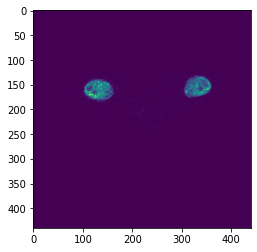

In [68]:
plt.imshow(wavelet_smoothed)

In [70]:
print(denoise_TV)



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


AttributeError: 'numpy.ndarray' object has no attribute 'pixel_array'

In [86]:
# Create some temporary filenames
suffix = '.IMA'
filename_little_endian = tempfile.NamedTemporaryFile(suffix=suffix).name
filename_big_endian = tempfile.NamedTemporaryFile(suffix=suffix).name

print("Setting file meta information...")
# Populate required values for file meta information
file_meta = FileMetaDataset()
file_meta.MediaStorageSOPClassUID = UID('1.2.840.10008.5.1.4.1.1.2')
file_meta.MediaStorageSOPInstanceUID = UID("1.2.3")
file_meta.ImplementationClassUID = UID("1.2.3.4")

print("Setting dataset values...")
# Create the FileDataset instance (initially no data elements, but file_meta
# supplied)
ds = FileDataset(filename_little_endian, {},
                 file_meta=file_meta, preamble=b"\0" * 128)

# Add the data elements -- not trying to set all required here. Check DICOM
# standard
ds.PatientName = "Test^Firstname"
ds.PatientID = "123456"

# Set the transfer syntax
ds.is_little_endian = True
ds.is_implicit_VR = True

# Set creation date/time
dt = datetime.datetime.now()
ds.ContentDate = dt.strftime('%Y%m%d')
timeStr = dt.strftime('%H%M%S.%f')  # long format with micro seconds
ds.ContentTime = timeStr

ds.PixelData = denoise_TV.tobytes()
print("Writing test file", filename_little_endian)
ds.save_as(filename_little_endian)
print("File saved.")

# Write as a different transfer syntax XXX shouldn't need this but pydicom
# 0.9.5 bug not recognizing transfer syntax
ds.file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRBigEndian
ds.is_little_endian = False
ds.is_implicit_VR = False

print("Writing test file as Big Endian Explicit VR", filename_big_endian)
ds.save_as(filename_big_endian)

# reopen the data just for checking
for filename in (filename_little_endian, filename_big_endian):
    print('Load file {} ...'.format(filename))
    ds = pydicom.dcmread(filename)
    print(ds)

    # remove the created file
    print('Remove file {} ...'.format(filename))
   # os.remove(filename)

Setting file meta information...
Setting dataset values...
Writing test file /var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/tmpyfc12viu.IMA
File saved.
Writing test file as Big Endian Explicit VR /var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/tmpqeyj_8rq.IMA
Load file /var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/tmpyfc12viu.IMA ...
Dataset.file_meta -------------------------------
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.3
(0002, 0012) Implementation Class UID            UI: 1.2.3.4
-------------------------------------------------
(0008, 0023) Content Date                        DA: '20221025'
(0008, 0033) Content Time                        TM: '110347.005370'
(0010, 0010) Patient's Name                      PN: 'Test^Firstname'
(0010, 0020) Patient ID                          LO: '123456'
(7fe0, 0010) Pixel Data                          OW: Array of 774400 elements
Remove file /var/folders/

In [91]:
files = glob("/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/tmpqeyj_8rq.IMA")
files

print(files)




['/var/folders/y2/pfrk_qsd50bcvhnzr1hxz26c0000gn/T/tmpqeyj_8rq.IMA']


# Test and exporting

/Users/randyllpandohie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


PSNR of input noisy image =  4.84969899620915
PSNR of cleaned image =  4.84969899620915


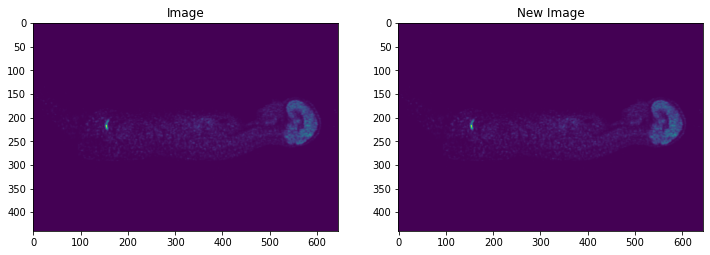

In [136]:
all_images=glob.glob('./data/test/020822_1_20220802_171408/DRF_100.nii.gz')




test_image=nib.load(all_images[0]).get_data()

noisy_img = test_image
#noisy_img = img_as_float(test_image) 

wavelet_smoothed = denoise_wavelet(noisy_img, multichannel=False,
                           method='BayesShrink', mode='soft',
                           rescale_sigma=True,wavelet='db2')

#denoise_TV = denoise_tv_chambolle(noisy_img, weight=0.7, multichannel=False)
denoise_TV = denoise_tv_chambolle(wavelet_smoothed, weight=0.7, multichannel=False)


fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6))
ax1.imshow(test_image[test_image.shape[0]//2])
ax1.set_title('Image')
ax2.imshow( denoise_TV[denoise_TV.shape[0]//2])
ax2.set_title('New Image')


noise_psnr = peak_signal_noise_ratio(noisy_img, denoise_TV, data_range=1.0)
TV_cleaned_psnr = peak_signal_noise_ratio(noisy_img, denoise_TV, data_range=1.0)
print("PSNR of input noisy image = ", noise_psnr)
print("PSNR of cleaned image = ", TV_cleaned_psnr)


img = nib.Nifti1Image(denoise_TV, np.eye(4))
img.get_data_dtype() == np.dtype(np.int16)

img.header.get_xyzt_units()

nib.save(img, os.path.join('./build', 'test4d.nii.gz'))  
